In [1]:
import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from PIL import Image
from matplotlib.colors import ListedColormap

# image_dir = "/content/drive/MyDrive/thesis-dataset/aug_data/aug_data/images"
# mask_dir = "/content/drive/MyDrive/thesis-dataset/aug_data/aug_data/masks"

image_dir = "D:/THESIS/thesis-dataset/aug_data/aug_data/images"
mask_dir = "D:/THESIS/thesis-dataset/aug_data/aug_data/masks"

IMG_WIDTH, IMG_HEIGHT = 256, 256
BATCH_SIZE = 8
SEED = 42
torch.manual_seed(SEED)

Unique classes in mask: [ 0 38]


C:\Users\saad0\AppData\Local\Temp\ipykernel_5396\3497369617.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ListedColormap(plt.cm.get_cmap("tab20", num_classes).colors)


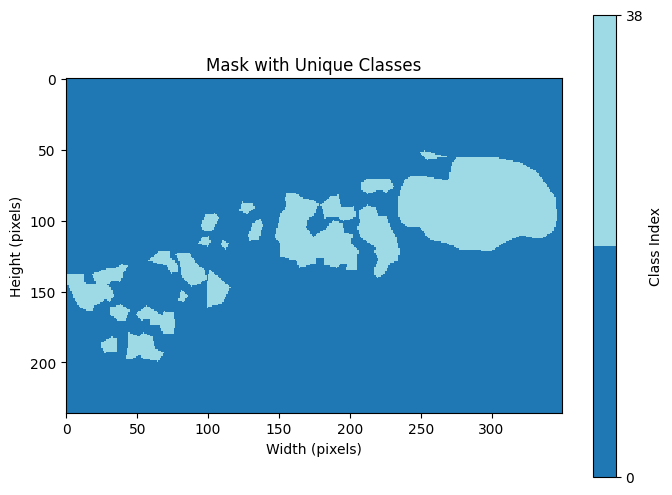

In [2]:
def visualize_label_mapping(mask_path):
    mask = Image.open(mask_path).convert("L")
    mask_array = np.array(mask)

    unique_classes = np.unique(mask_array)
    num_classes = len(unique_classes)
    print(f"Unique classes in mask: {unique_classes}")

    cmap = (
        ListedColormap(plt.cm.get_cmap("tab20", num_classes).colors)
        if num_classes <= 20
        else plt.cm.get_cmap("viridis", num_classes)
    )

    plt.figure(figsize=(8, 6))
    plt.imshow(mask_array, cmap=cmap, interpolation="nearest")
    plt.colorbar(ticks=unique_classes, label="Class Index")
    plt.title("Mask with Unique Classes")
    plt.xlabel("Width (pixels)")
    plt.ylabel("Height (pixels)")
    plt.grid(False)
    plt.show()


# custom_mask_path = '/content/drive/MyDrive/thesis-dataset/aug_data/aug_data/masks/00002_0.png'
custom_mask_path = "D:/THESIS/thesis-dataset/aug_data/aug_data/masks/00002_0.png"
visualize_label_mapping(custom_mask_path)

In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
                transforms.Normalize(mean=[0.5], std=[0.5]),
            ]
        )

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        image = self.transform(image)
        mask = torch.from_numpy(
            np.array(mask.resize((IMG_WIDTH, IMG_HEIGHT), Image.Resampling.NEAREST))
        ).long()
        return image, mask


dataset = SegmentationDataset(image_dir, mask_dir)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"Total Dataset: {len(dataset)}")
print(f"Train Size: {len(train_dataset)}")
print(f"Validation Size: {len(val_dataset)}")
print(f"Test Size: {len(test_dataset)}")

Total Dataset: 2940
Train Size: 2058
Validation Size: 441
Test Size: 441


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


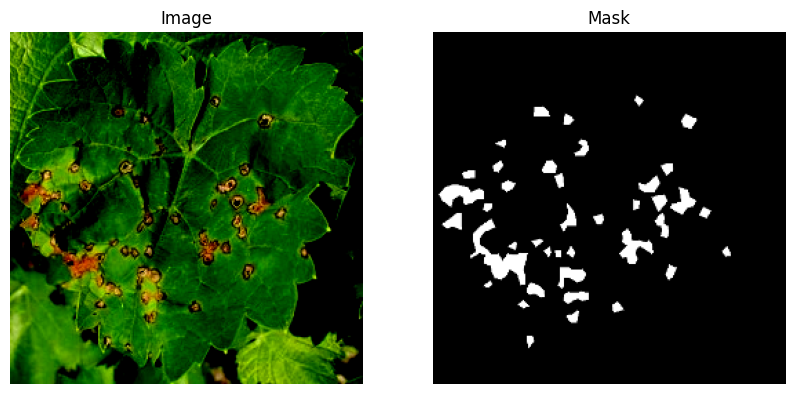

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.77169967].


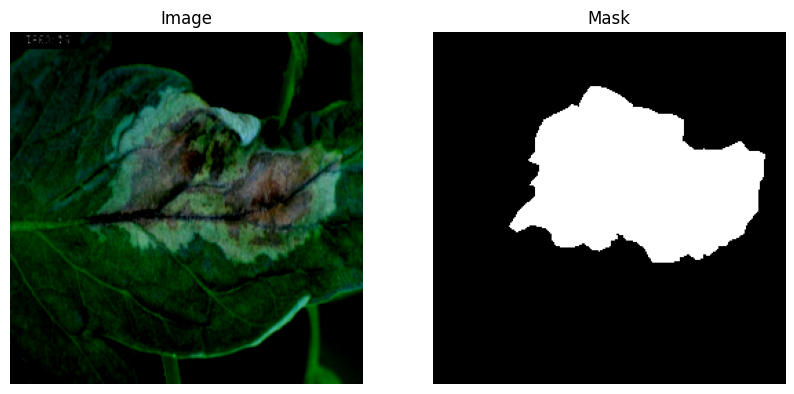

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


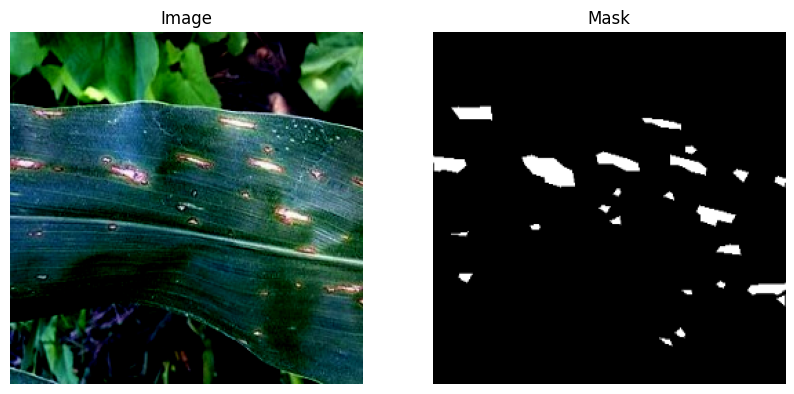

In [4]:
def show_data_samples(dataset, num_samples=5):
    for i in range(num_samples):
        image, mask = dataset[i]
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title("Image")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray")
        plt.title("Mask")
        plt.axis("off")
        plt.show()


show_data_samples(train_dataset, num_samples=3)

In [5]:
def count_rgb_images(split_dataset):
    rgb_count = 0
    non_rgb_count = 0

    for idx in range(len(split_dataset)):
        image, _ = split_dataset[idx]
        if image.shape[0] == 3:
            rgb_count += 1
        else:
            non_rgb_count += 1

    return rgb_count, non_rgb_count


train_rgb, train_non_rgb = count_rgb_images(train_dataset)
val_rgb, val_non_rgb = count_rgb_images(val_dataset)
test_rgb, test_non_rgb = count_rgb_images(test_dataset)

print(f"Train Dataset: {train_rgb} RGB, {train_non_rgb} Non-RGB")
print(f"Validation Dataset: {val_rgb} RGB, {val_non_rgb} Non-RGB")
print(f"Test Dataset: {test_rgb} RGB, {test_non_rgb} Non-RGB")

Train Dataset: 2058 RGB, 0 Non-RGB
Validation Dataset: 441 RGB, 0 Non-RGB
Test Dataset: 441 RGB, 0 Non-RGB


In [6]:
def count_mask_types(mask_dir):
    binary_count = 0
    multiclass_count = 0

    mask_files = os.listdir(mask_dir)
    if not mask_files:
        print(f"No files found in the directory: {mask_dir}")
        return

    for mask_file in mask_files:
        mask_path = os.path.join(mask_dir, mask_file)

        try:
            mask = np.array(Image.open(mask_path))
            unique_values = np.unique(mask)

            if len(unique_values) == 2:
                binary_count += 1
            else:
                multiclass_count += 1
        except Exception as e:
            print(f"Error processing {mask_file}: {e}")

    print(f"Number of Binary Masks: {binary_count}")
    print(f"Number of Multi-class Masks: {multiclass_count}")
    print(f"Total Masks: {binary_count + multiclass_count}")
    print(f"Percentage of Binary Masks: {(binary_count / len(mask_files)) * 100:.2f}%")
    print(
        f"Percentage of Multi-class Masks: {(multiclass_count / len(mask_files)) * 100:.2f}%"
    )


count_mask_types(mask_dir)

Number of Binary Masks: 1560
Number of Multi-class Masks: 1380
Total Masks: 2940
Percentage of Binary Masks: 53.06%
Percentage of Multi-class Masks: 46.94%


In [7]:
# analyze_class_distribution(train_dataset) only processes masks included in the train_dataset split.
# IMBALANCED


def analyze_class_distribution(dataset):
    class_counts = Counter()

    for _, mask in dataset:
        unique, counts = np.unique(mask.numpy(), return_counts=True)
        class_counts.update(dict(zip(unique, counts)))

    print("Class distribution in dataset:")
    for cls, count in class_counts.items():
        print(f"Class {cls}: {count} pixels")


analyze_class_distribution(train_dataset)

Class distribution in dataset:
Class 0: 112660552 pixels
Class 1: 30934 pixels
Class 2: 35779 pixels
Class 3: 26134 pixels
Class 4: 28654 pixels
Class 5: 31963 pixels
Class 6: 22372 pixels
Class 7: 20821 pixels
Class 8: 29667 pixels
Class 9: 23683 pixels
Class 10: 22753 pixels
Class 11: 26288 pixels
Class 12: 19756 pixels
Class 13: 22044 pixels
Class 14: 30222 pixels
Class 15: 19905 pixels
Class 16: 18310 pixels
Class 17: 26664 pixels
Class 18: 19412 pixels
Class 19: 28207 pixels
Class 20: 27403 pixels
Class 21: 19213 pixels
Class 22: 20684 pixels
Class 23: 29673 pixels
Class 24: 19451 pixels
Class 25: 20612 pixels
Class 26: 26015 pixels
Class 27: 21362 pixels
Class 28: 21351 pixels
Class 29: 29338 pixels
Class 30: 20395 pixels
Class 31: 29198 pixels
Class 32: 23824 pixels
Class 33: 28311 pixels
Class 34: 34464 pixels
Class 35: 24503 pixels
Class 36: 26583 pixels
Class 37: 43376 pixels
Class 38: 21263212 pixels


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


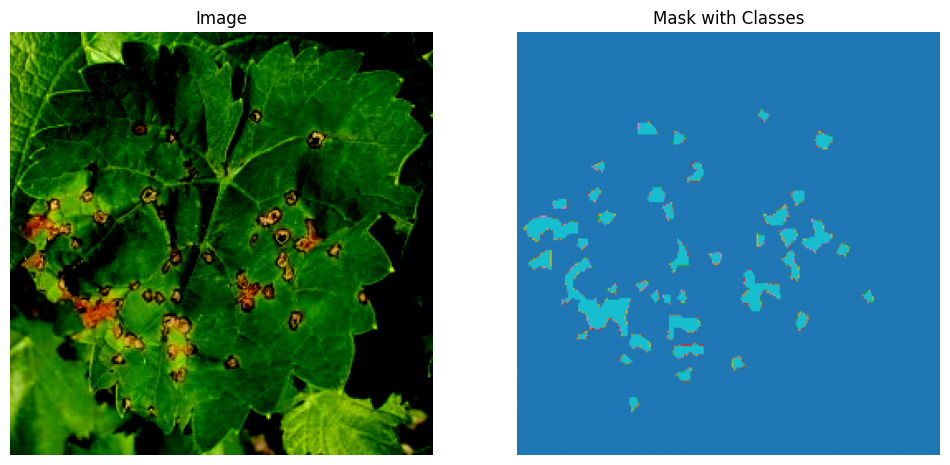

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.77169967].


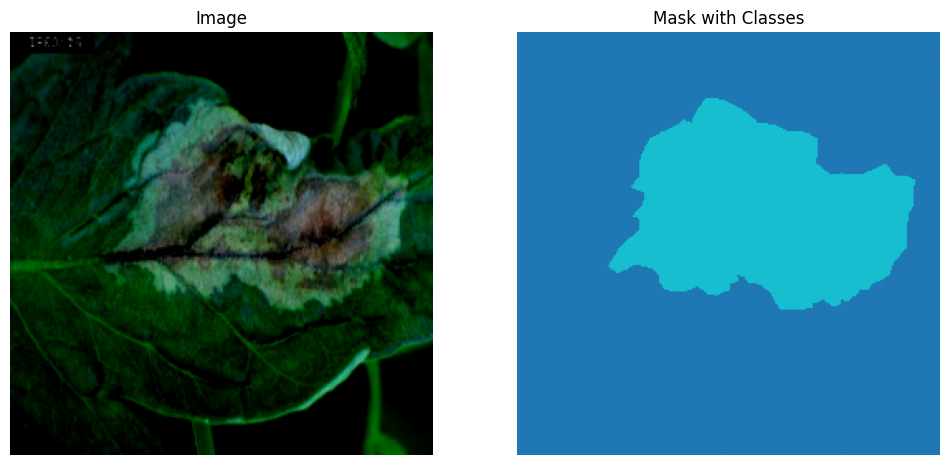

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


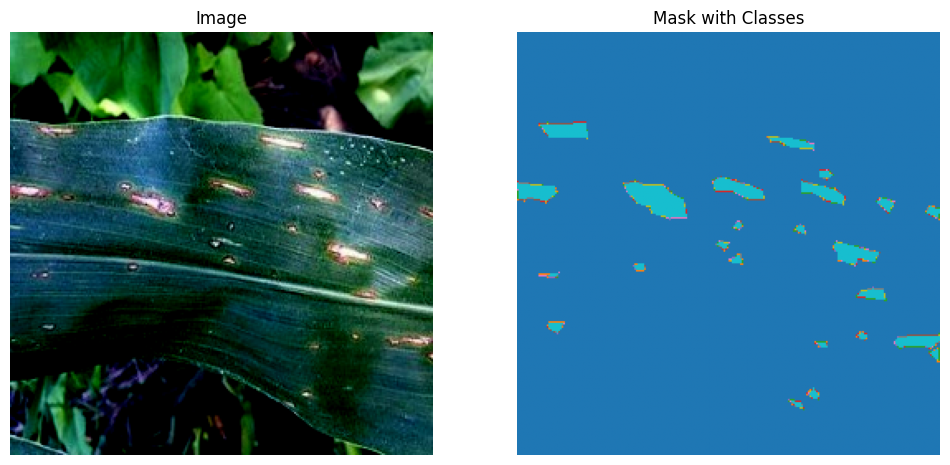

In [8]:
def inspect_dataset(dataset, num_samples=5):
    for i in range(num_samples):
        image, mask = dataset[i]
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image.permute(1, 2, 0).numpy())
        plt.title("Image")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(mask.numpy(), cmap="tab10")
        plt.title("Mask with Classes")
        plt.axis("off")
        plt.show()


inspect_dataset(train_dataset, num_samples=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.9764708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..0.99866724].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.6986189].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235307].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0000002].


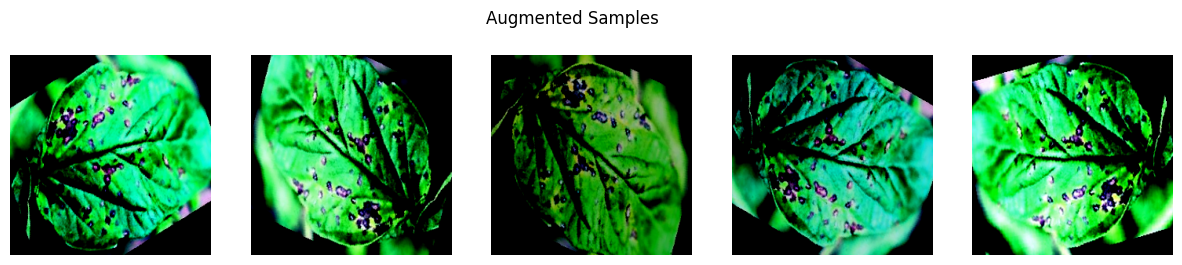

In [9]:
augmentation_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)


def visualize_augmentations(image_path, num_augmentations=5):
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(15, 3))
    for i in range(num_augmentations):
        augmented_image = augmentation_transform(image)
        plt.subplot(1, num_augmentations, i + 1)
        plt.imshow(augmented_image.permute(1, 2, 0).numpy())
        plt.axis("off")
    plt.suptitle("Augmented Samples")
    plt.show()


visualize_augmentations(os.path.join(image_dir, os.listdir(image_dir)[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


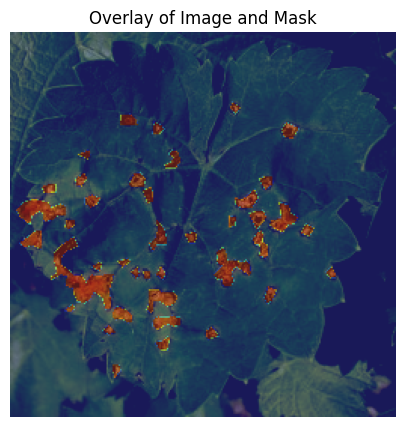

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.77169967].


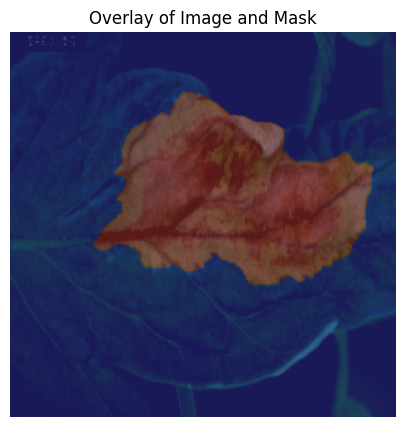

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


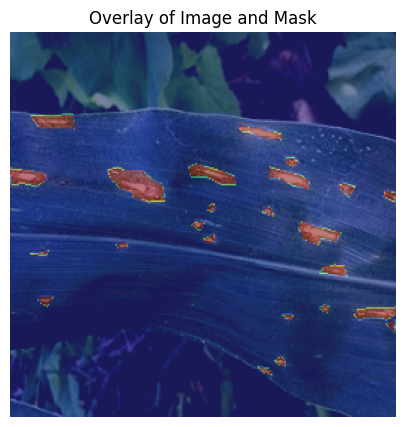

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.88235295].


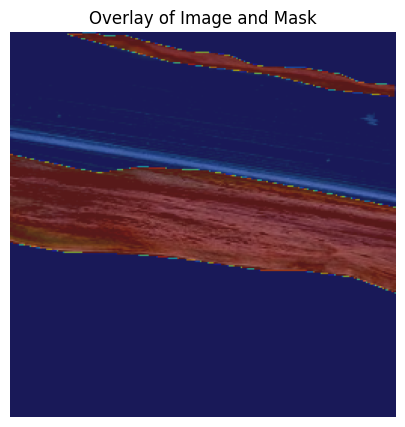

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.98538125].


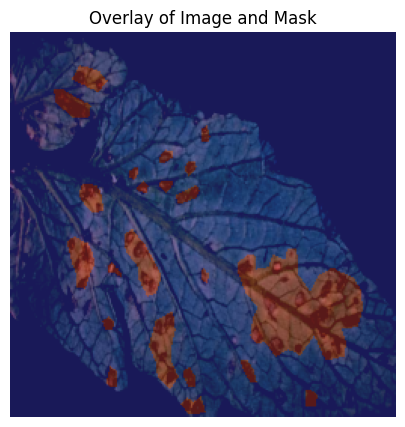

In [10]:
def overlay_masks(image, mask):
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(image_np, alpha=0.8)
    plt.imshow(mask_np, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.title("Overlay of Image and Mask")
    plt.show()


for i in range(5):
    image, mask = train_dataset[i]
    overlay_masks(image, mask)

In [11]:
def dataset_summary(dataset):
    total_images = len(dataset)
    heights, widths = [], []
    class_counts = Counter()

    for image, mask in dataset:
        heights.append(image.shape[1])
        widths.append(image.shape[2])
        unique, counts = np.unique(mask.numpy(), return_counts=True)
        class_counts.update(dict(zip(unique, counts)))

    print(f"Total Images: {total_images}")
    print(
        f"Image Dimensions: Min={min(heights)}x{min(widths)}, Max={max(heights)}x{max(widths)}"
    )


dataset_summary(train_dataset)

Total Images: 2058
Image Dimensions: Min=256x256, Max=256x256


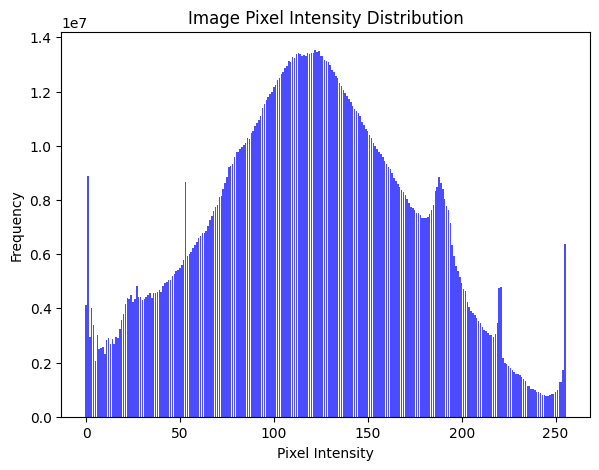

In [12]:
def pixel_intensity_analysis(image_dir, mask_dir):
    image_intensity_counts = np.zeros(256)
    mask_class_counts = {}

    for image_file, mask_file in zip(
        sorted(os.listdir(image_dir)), sorted(os.listdir(mask_dir))
    ):
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, mask_file)

        image = np.array(Image.open(image_path).convert("L"))
        mask = np.array(Image.open(mask_path))

        unique, counts = np.unique(image, return_counts=True)
        image_intensity_counts[unique] += counts

        unique_classes, counts_classes = np.unique(mask, return_counts=True)
        for cls, count in zip(unique_classes, counts_classes):
            mask_class_counts[cls] = mask_class_counts.get(cls, 0) + count

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.bar(range(256), image_intensity_counts, color="blue", alpha=0.7)
    plt.title("Image Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")


pixel_intensity_analysis(image_dir, mask_dir)

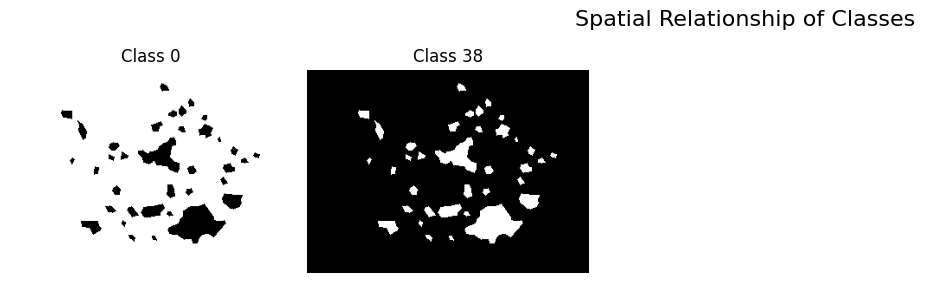

In [13]:
def visualize_class_relationships(mask_path):
    mask = np.array(Image.open(mask_path).convert("L"))
    unique_classes = np.unique(mask)

    num_classes = len(unique_classes)
    cols = 5
    rows = (num_classes + cols - 1) // cols

    plt.figure(figsize=(15, 3 * rows))

    for idx, cls in enumerate(unique_classes):
        binary_mask = (mask == cls).astype(np.uint8)
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(binary_mask, cmap="gray")
        plt.title(f"Class {cls}")
        plt.axis("off")

    plt.suptitle("Spatial Relationship of Classes", fontsize=16)
    plt.tight_layout()
    plt.show()


mask_example_path = os.path.join(mask_dir, os.listdir(mask_dir)[0])
visualize_class_relationships(mask_example_path)

Class Pixel Counts:
Class 0: 1538658705 pixels
Class 38: 270806410 pixels
Class 1: 44710 pixels
Class 2: 52005 pixels
Class 3: 37915 pixels
Class 4: 41095 pixels
Class 5: 45935 pixels
Class 6: 32470 pixels
Class 7: 30120 pixels
Class 8: 42660 pixels
Class 9: 34140 pixels
Class 10: 32135 pixels
Class 11: 38555 pixels
Class 12: 28490 pixels
Class 13: 31520 pixels
Class 14: 43465 pixels
Class 15: 28800 pixels
Class 16: 26825 pixels
Class 17: 38945 pixels
Class 18: 27995 pixels
Class 19: 38560 pixels
Class 20: 39465 pixels
Class 21: 27635 pixels
Class 22: 30130 pixels
Class 23: 43050 pixels
Class 24: 27640 pixels
Class 25: 29625 pixels
Class 26: 37140 pixels
Class 27: 31485 pixels
Class 28: 30225 pixels
Class 29: 42650 pixels
Class 30: 28985 pixels
Class 31: 41445 pixels
Class 32: 33855 pixels
Class 33: 41125 pixels
Class 34: 49135 pixels
Class 35: 35525 pixels
Class 36: 38420 pixels
Class 37: 61745 pixels


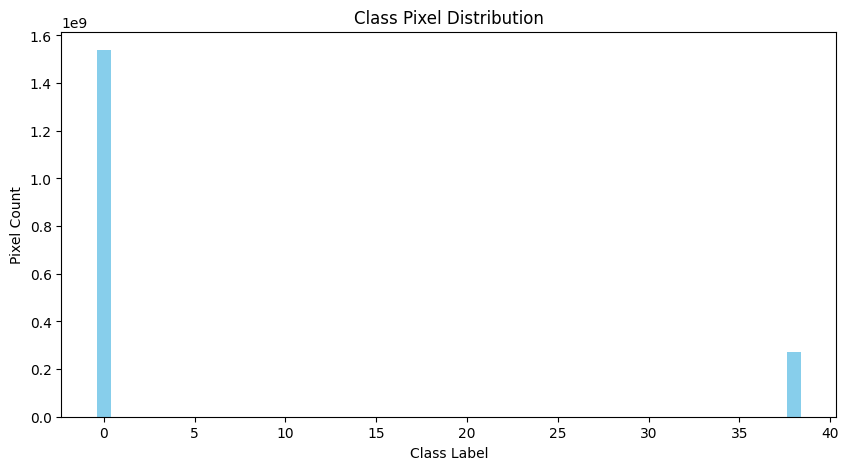

In [14]:
# check_class_imbalance(mask_dir) analyzes all masks in the mask_dir.
# IMBALANCE

from collections import Counter


def check_class_imbalance(mask_dir):
    class_counts = Counter()
    for mask_file in sorted(os.listdir(mask_dir)):
        mask_path = os.path.join(mask_dir, mask_file)
        mask = np.array(Image.open(mask_path).convert("L"))
        unique, counts = np.unique(mask, return_counts=True)
        class_counts.update(dict(zip(unique, counts)))

    print("Class Pixel Counts:")
    for cls, count in class_counts.items():
        print(f"Class {cls}: {count} pixels")

    classes, counts = zip(*sorted(class_counts.items()))
    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color="skyblue")
    plt.xlabel("Class Label")
    plt.ylabel("Pixel Count")
    plt.title("Class Pixel Distribution")
    plt.show()


check_class_imbalance(mask_dir)

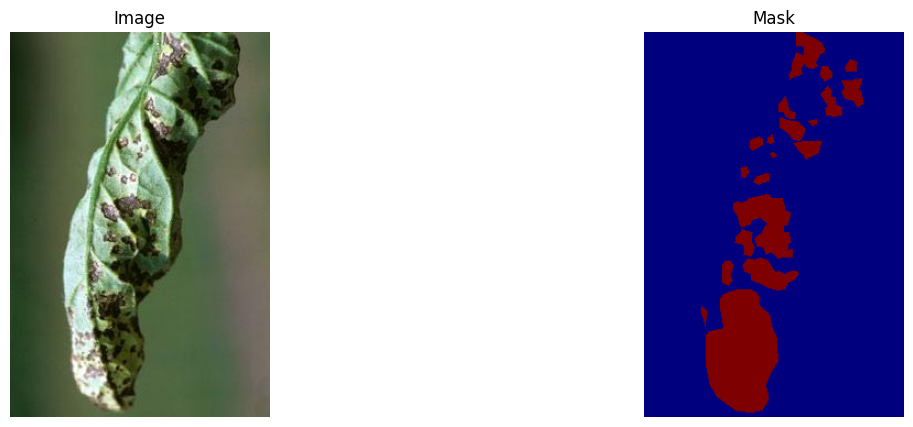

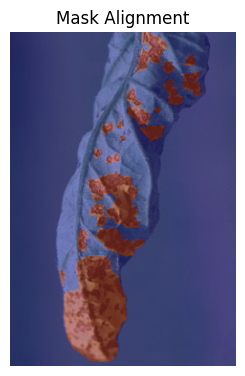

In [15]:
def check_mask_alignment(image_path, mask_path):
    image = np.array(Image.open(image_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="jet")
    plt.title("Mask")
    plt.axis("off")
    plt.show()

    plt.subplot(1, 2, 2)
    plt.imshow(image, alpha=0.8)
    plt.imshow(mask, cmap="jet", alpha=0.5)
    plt.title("Mask Alignment")
    plt.axis("off")
    plt.show()


# custom_image_path = "/content/drive/MyDrive/thesis-dataset/aug_data/aug_data/images/00002_1.jpg"
# custom_mask_path = "/content/drive/MyDrive/thesis-dataset/aug_data/aug_data/masks/00002_1.png"

custom_image_path = "D:/THESIS/thesis-dataset/aug_data/aug_data/images/00002_1.jpg"
custom_mask_path = "D:/THESIS/thesis-dataset/aug_data/aug_data/masks/00002_1.png"
check_mask_alignment(custom_image_path, custom_mask_path)

U-Net++

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


class UNetPlusPlus(nn.Module):
    def __init__(self, num_classes=2, in_channels=3):
        super(UNetPlusPlus, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.conv1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(192, 64, kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):

        enc1 = self.encoder(x)

        dec1 = self.conv1(enc1)

        dec2 = self.conv2(torch.cat([enc1, dec1], dim=1))

        dec3 = self.conv3(torch.cat([enc1, dec1, dec2], dim=1))

        output = self.final_conv(dec3)

        return output


LEARNING_RATE = 1e-3
EPOCHS = 500
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = UNetPlusPlus(num_classes=39, in_channels=3).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5, verbose=True
)
early_stopping_patience = 10
best_val_loss = float("inf")
early_stopping_counter = 0


def train_fn(loader, model, optimizer, loss_fn, device):
    model.train()
    loop = tqdm(loader, total=len(loader), desc="Training")
    epoch_loss = 0

    for data, targets in loop:
        data, targets = data.to(device), targets.to(device)

        predictions = model(data)
        loss = loss_fn(predictions, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return epoch_loss / len(loader)


def validate_fn(loader, model, loss_fn, device):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            val_loss += loss.item()

    return val_loss / len(loader)


train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")

    train_loss = train_fn(train_loader, model, optimizer, criterion, DEVICE)
    val_loss = validate_fn(val_loader, model, criterion, DEVICE)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), "best_unetplusplus_model.pth")
        print("Validation loss improved. Model saved.")
    else:
        early_stopping_counter += 1
        print(
            f"No improvement in validation loss. Early stopping counter: {early_stopping_counter}"
        )

    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered. Exiting training loop.")
        break

plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.show()

model.load_state_dict(torch.load("best_unetplusplus_model.pth"))
model.eval()
test_loss = validate_fn(test_loader, model, criterion, DEVICE)
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/500


Training: 100%|████████████████████████████████████████████████████████| 258/258 [1:08:43<00:00, 15.98s/it, loss=0.245]


Training Loss: 0.4748 | Validation Loss: 0.3921
Validation loss improved. Model saved.
Epoch 2/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [37:55<00:00,  8.82s/it, loss=0.309]


Training Loss: 0.3991 | Validation Loss: 0.3861
Validation loss improved. Model saved.
Epoch 3/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [36:42<00:00,  8.54s/it, loss=0.327]


Training Loss: 0.3871 | Validation Loss: 0.3689
Validation loss improved. Model saved.
Epoch 4/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [36:41<00:00,  8.53s/it, loss=0.482]


Training Loss: 0.3793 | Validation Loss: 0.3650
Validation loss improved. Model saved.
Epoch 5/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [39:51<00:00,  9.27s/it, loss=0.176]


Training Loss: 0.3668 | Validation Loss: 0.3654
No improvement in validation loss. Early stopping counter: 1
Epoch 6/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [38:05<00:00,  8.86s/it, loss=0.375]


Training Loss: 0.3597 | Validation Loss: 0.3499
Validation loss improved. Model saved.
Epoch 7/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [38:40<00:00,  9.00s/it, loss=0.558]


Training Loss: 0.3513 | Validation Loss: 0.3402
Validation loss improved. Model saved.
Epoch 8/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [58:07<00:00, 13.52s/it, loss=0.243]


Training Loss: 0.3499 | Validation Loss: 0.3426
No improvement in validation loss. Early stopping counter: 1
Epoch 9/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [41:03<00:00,  9.55s/it, loss=0.346]


Training Loss: 0.3487 | Validation Loss: 0.3435
No improvement in validation loss. Early stopping counter: 2
Epoch 10/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [38:33<00:00,  8.97s/it, loss=0.275]


Training Loss: 0.3444 | Validation Loss: 0.3409
No improvement in validation loss. Early stopping counter: 3
Epoch 11/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [36:12<00:00,  8.42s/it, loss=0.784]


Training Loss: 0.3401 | Validation Loss: 0.3295
Validation loss improved. Model saved.
Epoch 12/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [37:16<00:00,  8.67s/it, loss=0.143]


Training Loss: 0.3359 | Validation Loss: 0.3363
No improvement in validation loss. Early stopping counter: 1
Epoch 13/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [36:37<00:00,  8.52s/it, loss=0.126]


Training Loss: 0.3343 | Validation Loss: 0.3246
Validation loss improved. Model saved.
Epoch 14/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [36:21<00:00,  8.45s/it, loss=0.315]


Training Loss: 0.3377 | Validation Loss: 0.3236
Validation loss improved. Model saved.
Epoch 15/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [36:24<00:00,  8.47s/it, loss=0.242]


Training Loss: 0.3339 | Validation Loss: 0.3228
Validation loss improved. Model saved.
Epoch 16/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [36:19<00:00,  8.45s/it, loss=0.452]


Training Loss: 0.3299 | Validation Loss: 0.3305
No improvement in validation loss. Early stopping counter: 1
Epoch 17/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [36:57<00:00,  8.60s/it, loss=0.478]


Training Loss: 0.3261 | Validation Loss: 0.3180
Validation loss improved. Model saved.
Epoch 18/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [36:51<00:00,  8.57s/it, loss=0.353]


Training Loss: 0.3280 | Validation Loss: 0.3294
No improvement in validation loss. Early stopping counter: 1
Epoch 19/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [36:15<00:00,  8.43s/it, loss=0.361]


Training Loss: 0.3256 | Validation Loss: 0.3164
Validation loss improved. Model saved.
Epoch 20/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [36:44<00:00,  8.55s/it, loss=0.419]


Training Loss: 0.3225 | Validation Loss: 0.3145
Validation loss improved. Model saved.
Epoch 21/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [36:29<00:00,  8.49s/it, loss=0.197]


Training Loss: 0.3228 | Validation Loss: 0.3191
No improvement in validation loss. Early stopping counter: 1
Epoch 22/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [35:47<00:00,  8.33s/it, loss=0.304]


Training Loss: 0.3193 | Validation Loss: 0.3132
Validation loss improved. Model saved.
Epoch 23/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [35:42<00:00,  8.30s/it, loss=0.259]


Training Loss: 0.3177 | Validation Loss: 0.3136
No improvement in validation loss. Early stopping counter: 1
Epoch 24/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [49:11<00:00, 11.44s/it, loss=0.247]


Training Loss: 0.3171 | Validation Loss: 0.3139
No improvement in validation loss. Early stopping counter: 2
Epoch 25/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [46:14<00:00, 10.76s/it, loss=0.573]


Training Loss: 0.3182 | Validation Loss: 0.3149
No improvement in validation loss. Early stopping counter: 3
Epoch 26/500


Training: 100%|██████████████████████████████████████████████████████████| 258/258 [49:23<00:00, 11.49s/it, loss=0.171]


Training Loss: 0.3164 | Validation Loss: 0.3166
No improvement in validation loss. Early stopping counter: 4
Epoch 27/500


Training:   8%|████▌                                                      | 20/258 [03:32<41:11, 10.39s/it, loss=0.393]